<a href="https://colab.research.google.com/github/Vitalyastiy/courses/blob/main/08_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Преобразование количественных данных

In [ ]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# установим размер и стиль Seaborn для последующих графиков
sns.set(rc = {'figure.figsize' : (8, 5)})

### Подготовка данных

In [ ]:
# возьмем признак LSTAT (процент населения с низким социальным статусом) 
# и целевую переменную MEDV (медианная стоимость жилья)
boston = pd.read_csv('/content/boston.csv')[['LSTAT', 'MEDV']]
boston.shape

(506, 2)

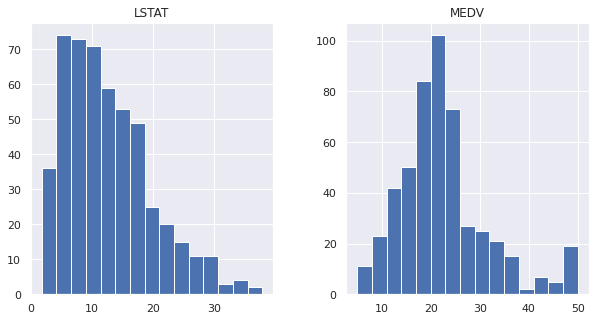

In [ ]:
# посмотрим на данные с помощью гистограммы
boston.hist(bins = 15, figsize = (10, 5));

In [ ]:
# посмотрим на основные статистические показатели
boston.describe()

,LSTAT,MEDV
count,506.000000,506.000000
mean,12.653063,22.532806
std,7.141062,9.197104
min,1.730000,5.000000
25%,6.950000,17.025000
50%,11.360000,21.200000
75%,16.955000,25.000000
max,37.970000,50.000000


#### Пример преобразований

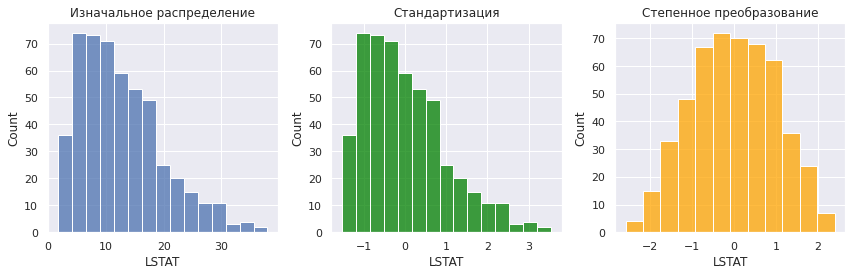

In [ ]:
# создадим сетку подграфиков 1 x 3
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

# на первом графике разместим изначальное распределение
sns.histplot(data = boston, x = 'LSTAT',
             bins = 15,
             ax = ax[0])
ax[0].set_title('Изначальное распределение')

# на втором - данные после стандартизации
sns.histplot(x = (boston.LSTAT - np.mean(boston.LSTAT)) / np.std(boston.LSTAT),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Стандартизация')

# наконец скачаем функцию степенного преобразования power_transform()
from sklearn.preprocessing import power_transform

# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(x = power_transform(boston[['LSTAT']],
                                 method = 'box-cox').flatten(),
             bins = 12, color = 'orange',
             ax = ax[2])
ax[2].set(title = 'Степенное преобразование', xlabel = 'LSTAT')

plt.tight_layout()
plt.show()

#### Добавление выбросов

In [ ]:
# сделаем копию датафрейма
boston_outlier = boston.copy()

# создадим два отличающихся наблюдения
outliers = [pd.Series([45, 70], index = boston_outlier.columns),
            pd.Series([50, 72], index = boston_outlier.columns)]

# добавим их в датафрейм
boston_outlier = boston_outlier.append(outliers, ignore_index = True)

# посмотрим на размерность нового датафрейма
boston_outlier.shape

(508, 2)

In [ ]:
# убедимся, что наблюдения добавились
boston_outlier.tail()

,LSTAT,MEDV
503,5.64,23.9
504,6.48,22.0
505,7.88,11.9
506,45.00,70.0
507,50.00,72.0


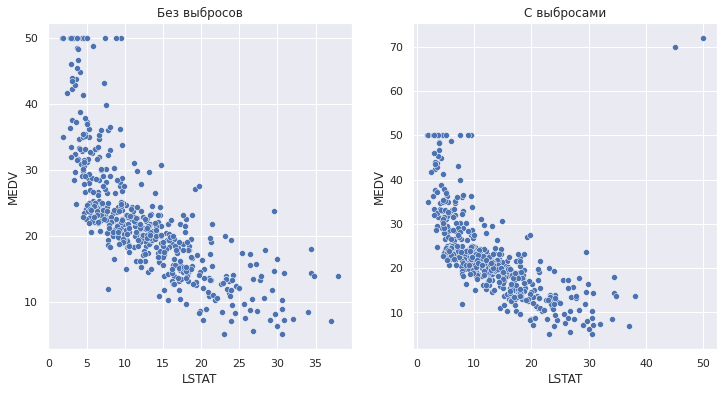

In [ ]:
# посмотрим на данные с выбросами и без
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sns.scatterplot(data = boston, x = 'LSTAT', y = 'MEDV', ax = ax[0]).set(title = 'Без выбросов')
sns.scatterplot(data = boston_outlier, x = 'LSTAT', y = 'MEDV', ax = ax[1]).set(title = 'С выбросами');

## Линейные преобразования

### Стандартизация

#### Стандартизация вручную

In [ ]:
((boston - np.mean(boston)) / np.std(boston)).head(3)

,LSTAT,MEDV
0,-1.075562,0.159686
1,-0.492439,-0.101524
2,-1.208727,1.324247


#### StandardScaler

Преобразование данных

In [ ]:
# из модуля preprocessing импортируем класс StandardScaler
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler и применим метод .fit()
st_scaler = StandardScaler().fit(boston)
st_scaler

StandardScaler()

In [ ]:
# в данном случае метод .fit() находит среднее арифметическое
st_scaler.mean_

array([12.65306324, 22.53280632])

In [ ]:
# и СКО каждого столбца
st_scaler.scale_

array([7.13400164, 9.18801155])

In [ ]:
# метод .transform() возвращает массив Numpy с преобразованными значениями
boston_scaled = st_scaler.transform(boston)

# превратим массив в датафрейм с помощью функции pd.DataFrame()
pd.DataFrame(boston_scaled, columns = boston.columns).head(3)

,LSTAT,MEDV
0,-1.075562,0.159686
1,-0.492439,-0.101524
2,-1.208727,1.324247


In [ ]:
# метод .fit_transform() рассчитывает показатели среднего и СКО 
# и одновременно преобразует данные
boston_scaled = pd.DataFrame(StandardScaler().fit_transform(boston),
                             columns = boston.columns)

In [ ]:
boston_scaled.mean()

LSTAT   -3.089316e-16
MEDV    -5.195668e-16
dtype: float64

In [ ]:
boston_scaled.std()

LSTAT    1.00099
MEDV     1.00099
dtype: float64

In [ ]:
np.ptp(boston_scaled.LSTAT), np.ptp(boston_scaled.MEDV)

(5.079897909445279, 4.897686488337717)

In [ ]:
# аналогичным образом стандиртизируем данные с выбросами
boston_outlier_scaled = pd.DataFrame(StandardScaler().fit_transform(boston_outlier),
                                     columns = boston_outlier.columns)

In [ ]:
np.ptp(boston_outlier_scaled.LSTAT), np.ptp(boston_outlier_scaled.MEDV)

(6.4805002659537125, 6.936285192251757)

Визуализация преобразования

In [ ]:
# первая функция будет принимать на вход четыре датафрейма
# и визуализировать изменения с помощью точечной диаграммы
def scatter_plots(df, df_outlier, df_scaled, df_outlier_scaled, title):

  fig, ax = plt.subplots(2, 2, figsize = (12,12))

  sns.scatterplot(data = df, x = 'LSTAT', y = 'MEDV', ax = ax[0, 0])
  ax[0, 0].set_title('Изначальный без выбросов')

  sns.scatterplot(data = df_outlier, x = 'LSTAT', y = 'MEDV', color = 'green', ax = ax[0, 1])
  ax[0, 1].set_title('Изначальный с выбросами')

  sns.scatterplot(data = df_scaled, x = 'LSTAT', y = 'MEDV', ax = ax[1, 0])
  ax[1, 0].set_title('Преобразование без выбросов')

  sns.scatterplot(data = df_outlier_scaled, x = 'LSTAT', y = 'MEDV', color = 'green', ax = ax[1, 1])
  ax[1, 1].set_title('Преобразование с выбросами')

  plt.suptitle(title)
  plt.show()

In [ ]:
# вторая функция будет визуализировать изменения с помощью гистограммы
def hist_plots(df, df_outlier, df_scaled, df_outlier_scaled, title):

  fig, ax = plt.subplots(2, 2, figsize = (12,12))

  sns.histplot(data = df, x = 'LSTAT', ax = ax[0, 0])
  ax[0, 0].set_title('Изначальный без выбросов')

  sns.histplot(data = df_outlier, x = 'LSTAT', color = 'green', ax = ax[0, 1])
  ax[0, 1].set_title('Изначальный с выбросами')

  sns.histplot(data = df_scaled, x = 'LSTAT', ax = ax[1, 0])
  ax[1, 0].set_title('Преобразование без выбросов')

  sns.histplot(data = df_outlier_scaled, x = 'LSTAT', color = 'green', ax = ax[1, 1])
  ax[1, 1].set_title('Преобразование с выбросами')

  plt.suptitle(title)
  plt.show()

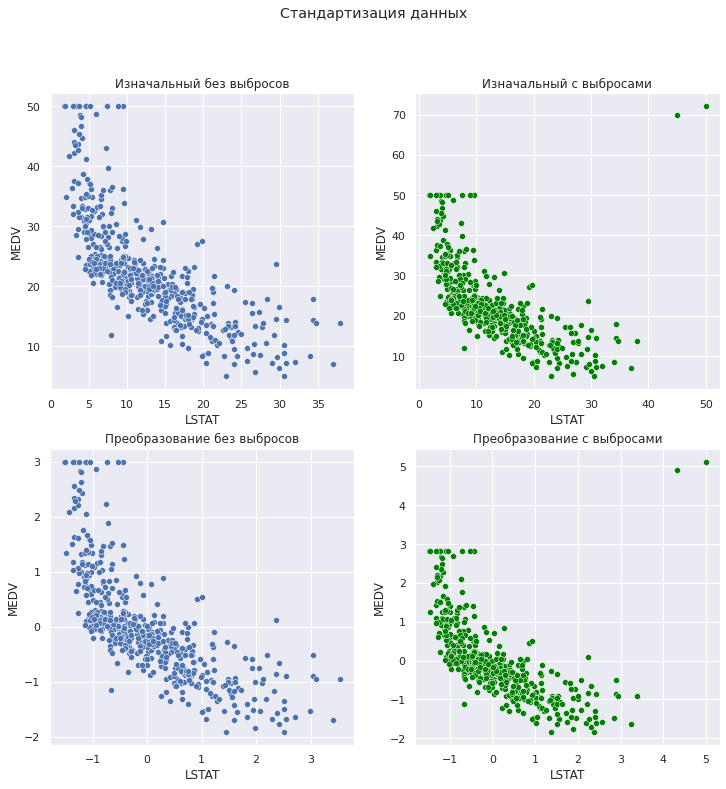

In [ ]:
# применим эти функции
scatter_plots(boston,
              boston_outlier,
              boston_scaled,
              boston_outlier_scaled,
              title = 'Стандартизация данных')

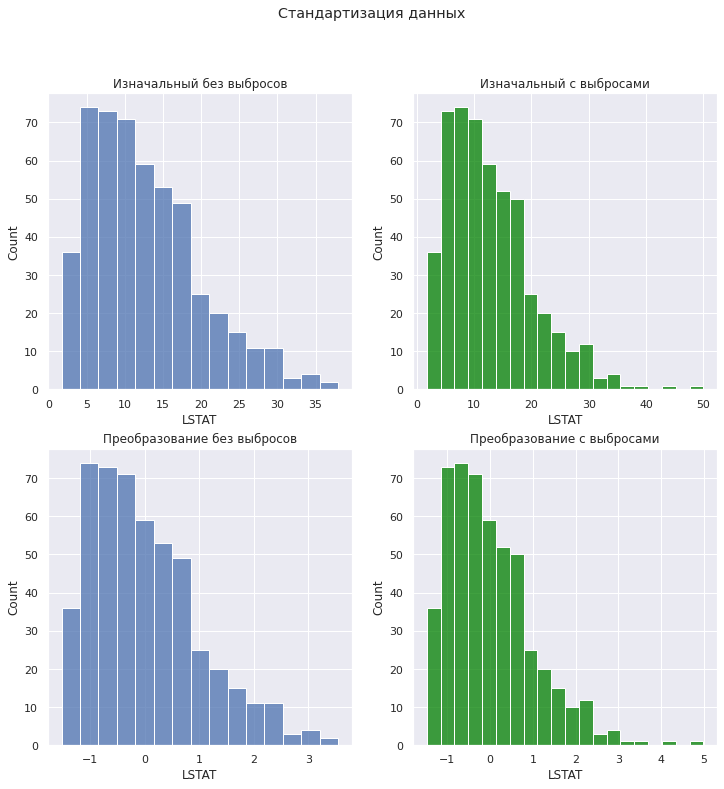

In [ ]:
hist_plots(boston,
           boston_outlier,
           boston_scaled,
           boston_outlier_scaled,
           title = 'Стандартизация данных')

Обратное преобразование

In [ ]:
# вернем исходный масштаб данных
boston_inverse = pd.DataFrame(st_scaler.inverse_transform(boston_scaled),
                              columns = boston.columns)

In [ ]:
# используем метод .equals(), чтобы выяснить, одинаковы ли датафреймы
boston.equals(boston_inverse)

False

In [ ]:
# вычтем значения одного датафрейма из значений другого
(boston - boston_inverse).head(3)

,LSTAT,MEDV
0,0.000000e+00,0.0
1,0.000000e+00,0.0
2,-8.881784e-16,0.0


#### Проблема утечки данных

In [ ]:
# импортируем данные о недвижимости в Калифорнии
from sklearn.datasets import fetch_california_housing

# при return_X_y = True вместо объекта Bunch возвращаются признаки (X) и целевая переменная (y)
# параметр as_frame = True возвращает датафрейм и Series вместо массивов Numpy
X, y = fetch_california_housing(return_X_y = True, as_frame = True)

# убедимся, что данные в нужном нам формате
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [ ]:
# посмотрим на признаки
X.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


In [ ]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42)

In [ ]:
# импортируем класс для стандартизации данных
from sklearn.preprocessing import StandardScaler
# и создания модели линейной регрессии
from sklearn.linear_model import LinearRegression

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

In [ ]:
# масштабируем признаки обучающей выборки
X_train_scaled = scaler.fit_transform(X_train)

# убедимся, что объект scaler запомнил значения среднего и СКО
# для каждого признака
scaler.mean_, scaler.scale_

(array([ 3.87831412e+00,  2.85959948e+01,  5.43559839e+00,  1.09688116e+00,
         1.42749729e+03,  3.10665968e+00,  3.56467196e+01, -1.19583736e+02]),
 array([1.90372658e+00, 1.26109222e+01, 2.42157219e+00, 4.38789636e-01,
        1.14289394e+03, 1.19554480e+01, 2.13388067e+00, 2.00237697e+00]))

In [ ]:
# применим масштабированные данные для обучения модели линейной регрессии
model = LinearRegression().fit(X_train_scaled, y_train)
model

LinearRegression()

In [ ]:
# преобразуем тестовые данные с использованием среднего и СКО, рассчитанных на обучающей выборке
# так тестовые данные не повляют на обучение модели, и мы избежим утечки данных
X_test_scaled = scaler.transform(X_test)

# сделаем прогноз на стандартизированных тестовых данных
y_pred = model.predict(X_test_scaled)
y_pred[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

In [ ]:
# и оценим R-квадрат (метрика (score) по умолчанию для класса LinearRegression)
model.score(X_test_scaled, y_test)

0.5910509795491352

#### Применение пайплайна

##### Класс make_pipeline

In [ ]:
# импортируем класс make_pipeline (упрощенный вариант класса Pipeline) из модуля pipeline
from sklearn.pipeline import make_pipeline

# создадим объект pipe, в который поместим объекты классов StandardScaler и LinearRegression
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
# одновременно применим масштабирование и создание модели регрессии на обучающей выборке
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
# теперь масштабируем тестовые данные (используя среднее и СКО обучающей части)
# и сделаем прогноз
pipe.predict(X_test)

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352])

In [ ]:
# метод .score() выполнит масштабирование, обучит модель, сделает прогноз и посчитает R-квадрат
pipe.score(X_test, y_test)

0.5910509795491352

In [ ]:
# сделать прогноз можно в одну строчку
make_pipeline(StandardScaler(), LinearRegression()).fit(X_train, y_train).predict(X_test)

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352])

In [ ]:
# как и посчитать R-квадрат
make_pipeline(StandardScaler(), LinearRegression()).fit(X_train, y_train).score(X_test, y_test)

0.5910509795491352

In [ ]:
# под капотом мы создали объект класса Pipeline
type(pipe)

sklearn.pipeline.Pipeline

##### Класс Pipeline

In [ ]:
# испортируем класс Pipeline
from sklearn.pipeline import Pipeline

# задаем названия и создаем объекты используемых классов
pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('lr', LinearRegression())],
                verbose = True)

In [ ]:
# рассчитаем коэффициент детерминации
pipe.fit(X_train, y_train).score(X_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s


0.5910509795491352

### Приведение к диапазону

#### MinMaxScaler

In [ ]:
# импортируем класс MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# создаем объект этого класса,
# в параметре feature_range оставим диапазон по умолчанию
minmax = MinMaxScaler(feature_range = (0, 1))
minmax

MinMaxScaler()

In [ ]:
# применим метод .fit() и
minmax.fit(boston)

# найдем минимальные и максимальные значения
minmax.data_min_, minmax.data_max_

(array([1.73, 5.  ]), array([37.97, 50.  ]))

In [ ]:
# приведем данные без выбросов (достаточно метода .transform())
boston_scaled = minmax.transform(boston)
# и с выбросами к заданному диапазону
boston_outlier_scaled = minmax.fit_transform(boston_outlier)

# преобразуем результаты в датафрейм
boston_scaled = pd.DataFrame(boston_scaled, columns = boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns = boston.columns)

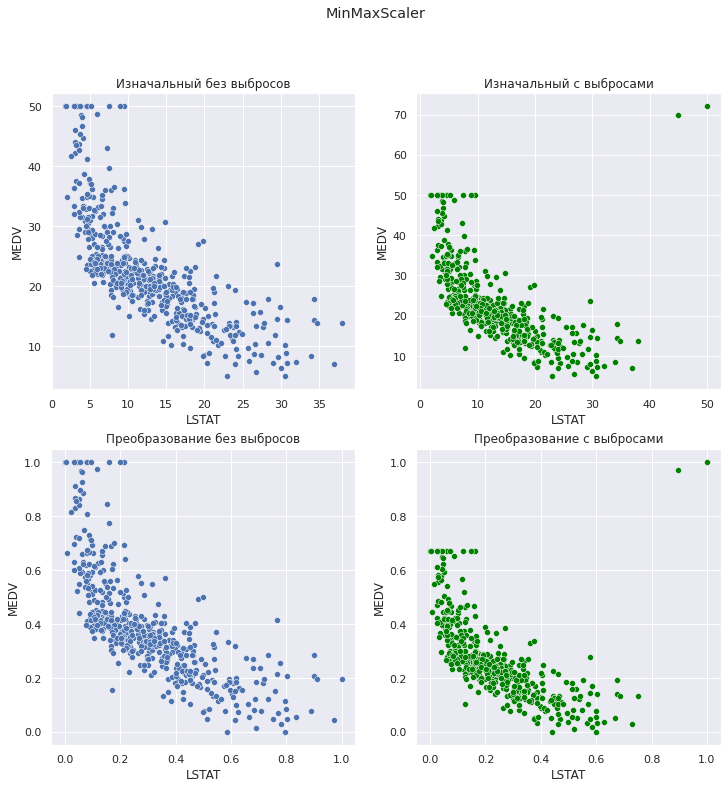

In [ ]:
# построим точечные диаграммы
scatter_plots(boston,
              boston_outlier,
              boston_scaled,
              boston_outlier_scaled,
              title = 'MinMaxScaler')

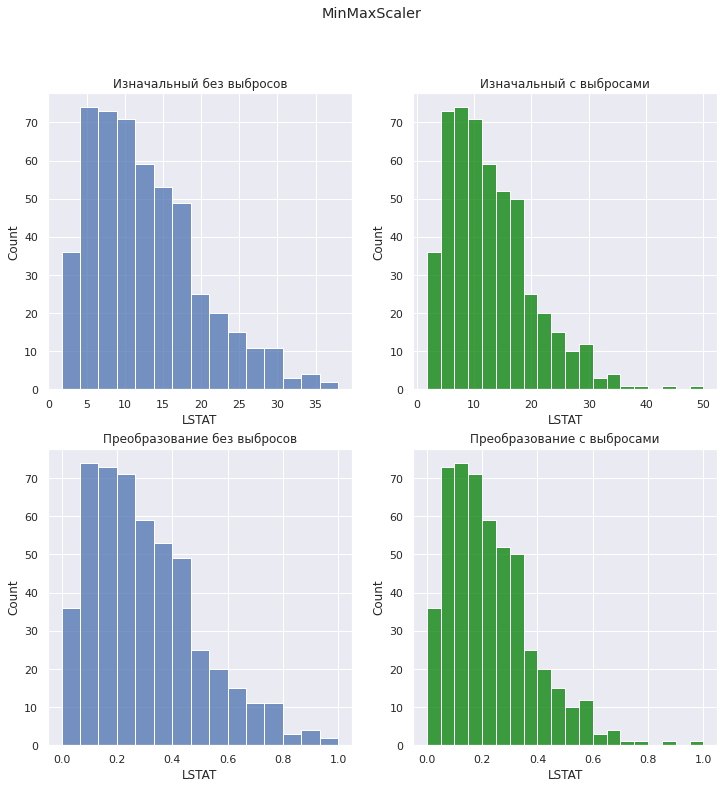

In [ ]:
# и гистограммы
hist_plots(boston,
           boston_outlier,
           boston_scaled,
           boston_outlier_scaled,
           title = 'MinMaxScaler')

#### MaxAbsScaler

Стандартизация разреженной матрицы

In [ ]:
# создадим разреженную матрицу с пятью признаками
sparse_data = {}

sparse_data['F1'] = [0, 0, 1.25, 0, 2.15, 0, 0, 0, 0, 0, 0, 0]
sparse_data['F2'] = [0, 0, 0, 0.45, 0, 1.20, 0, 0, 0, 1.28, 0, 0]
sparse_data['F3'] = [0, 0, 0, 0, 2.15, 0, 0, 0, 0.33, 0, 0, 0]
sparse_data['F4'] = [0, -6.5, 0, 0, 0, 0, 8.25, 0, 0, 0, 0, 0]
sparse_data['F5'] = [0, 0, 0, 0, 0, 3.17, 0, 0, 0, 0, 0, -1.85]

sparse_data = pd.DataFrame(sparse_data)
sparse_data

,F1,F2,F3,F4,F5
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-6.50,0.00
2,1.25,0.00,0.00,0.00,0.00
3,0.00,0.45,0.00,0.00,0.00
4,2.15,0.00,2.15,0.00,0.00
5,0.00,1.20,0.00,0.00,3.17
6,0.00,0.00,0.00,8.25,0.00
7,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.33,0.00,0.00
9,0.00,1.28,0.00,0.00,0.00


In [ ]:
# стандартизируем эти данные
pd.DataFrame(StandardScaler().fit_transform(sparse_data),
             columns = sparse_data.columns).round(2)

,F1,F2,F3,F4,F5
0,-0.43,-0.53,-0.35,-0.05,-0.10
1,-0.43,-0.53,-0.35,-2.19,-0.10
2,1.47,-0.53,-0.35,-0.05,-0.10
3,-0.43,0.45,-0.35,-0.05,-0.10
4,2.83,-0.53,3.28,-0.05,-0.10
5,-0.43,2.07,-0.35,-0.05,2.90
6,-0.43,-0.53,-0.35,2.68,-0.10
7,-0.43,-0.53,-0.35,-0.05,-0.10
8,-0.43,-0.53,0.21,-0.05,-0.10
9,-0.43,2.24,-0.35,-0.05,-0.10


Простой пример

In [ ]:
# создадим двумерный массив
arr = np.array([[ 1., -1., -2.],
                [ 2.,  0.,  0.],
                [ 0.,  1.,  1.]])

In [ ]:
# применим MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
maxabs = MaxAbsScaler()

maxabs.fit_transform(arr)

array([[ 0.5, -1. , -1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. ,  0.5]])

In [ ]:
# выведем модуль максимального значения каждого столбца
maxabs.scale_

array([2., 1., 2.])

Разреженная матрица и MaxAbsScaler

In [ ]:
pd.DataFrame(MaxAbsScaler().fit_transform(sparse_data),
             columns = sparse_data.columns).round(2)

,F1,F2,F3,F4,F5
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-0.79,0.00
2,0.58,0.00,0.00,0.00,0.00
3,0.00,0.35,0.00,0.00,0.00
4,1.00,0.00,1.00,0.00,0.00
5,0.00,0.94,0.00,0.00,1.00
6,0.00,0.00,0.00,1.00,0.00
7,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.15,0.00,0.00
9,0.00,1.00,0.00,0.00,0.00


Матрица csr и MaxAbsScaler

In [ ]:
# создадим матрицу в формате сжатого хранения строкой
from scipy.sparse import csr_matrix
csr_data = csr_matrix(sparse_data.values)
print(csr_data)

  (1, 3)	-6.5
  (2, 0)	1.25
  (3, 1)	0.45
  (4, 0)	2.15
  (4, 2)	2.15
  (5, 1)	1.2
  (5, 4)	3.17
  (6, 3)	8.25
  (8, 2)	0.33
  (9, 1)	1.28
  (11, 4)	-1.85


In [ ]:
# применим MaxAbsScaler
csr_data_scaled = MaxAbsScaler().fit_transform(csr_data)
print(csr_data_scaled)

  (1, 3)	-0.7878787878787878
  (2, 0)	0.5813953488372093
  (3, 1)	0.3515625
  (4, 0)	1.0
  (4, 2)	1.0
  (5, 1)	0.9375
  (5, 4)	0.9999999999999999
  (6, 3)	1.0
  (8, 2)	0.15348837209302327
  (9, 1)	1.0
  (11, 4)	-0.583596214511041


In [ ]:
# восстановим плотную матрицу
csr_data_scaled.todense().round(2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.79,  0.  ],
       [ 0.58,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.35,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.94,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.15,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.58]])

### Robust scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

boston_scaled = RobustScaler().fit_transform(boston)
boston_outlier_scaled = RobustScaler().fit_transform(boston_outlier)

boston_scaled = pd.DataFrame(boston_scaled, columns = boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns = boston.columns)

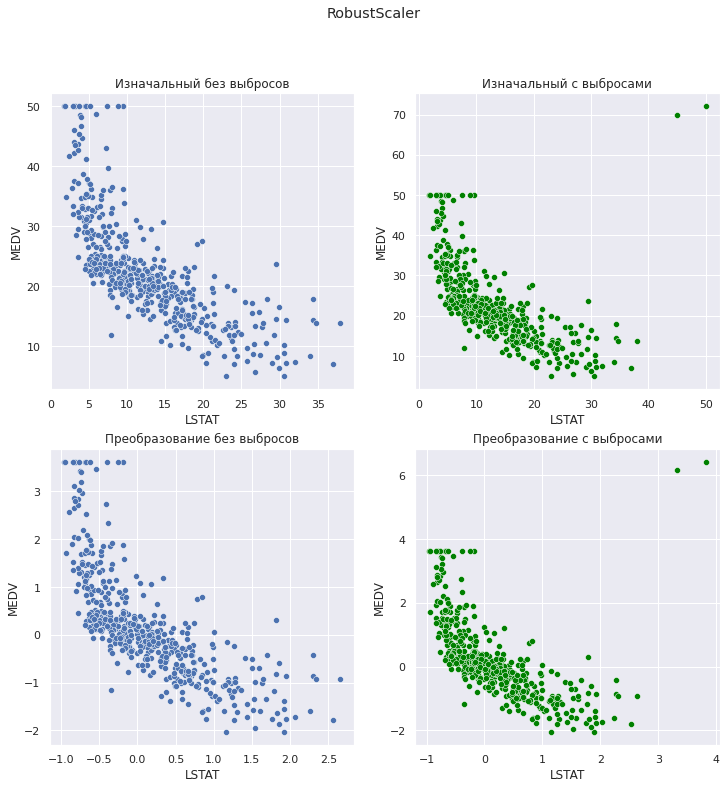

In [ ]:
scatter_plots(boston,
              boston_outlier,
              boston_scaled,
              boston_outlier_scaled,
              title = 'RobustScaler')

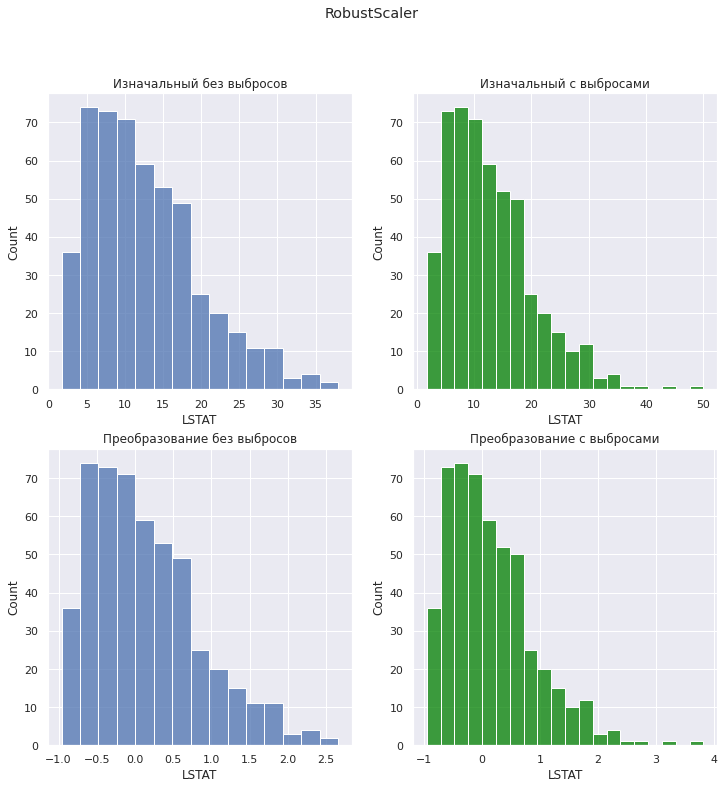

In [ ]:
hist_plots(boston,
           boston_outlier,
           boston_scaled,
           boston_outlier_scaled,
           title = 'RobustScaler')

### Класс Normalizer

#### Норма вектора

In [ ]:
# возькм вектор с координатами [4, 3] 
v = np.array([4, 3])

# и найдем его длину или L2 норму
l2norm = np.sqrt(v[0]**2 + v[1]**2)
l2norm

5.0

In [ ]:
# разделим каждый компонент вектора на его норму
v_normalized = v/l2norm
v_normalized

array([0.8, 0.6])

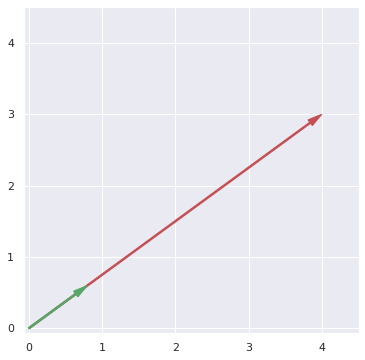

In [ ]:
# выведем оба вектора на графике
plt.figure(figsize = (6, 6))

ax = plt.axes()

plt.xlim([-0.07, 4.5])
plt.ylim([-0.07, 4.5])

ax.arrow(0, 0, v[0], v[1], width = 0.02, head_width = 0.1, head_length = 0.2, length_includes_head = True, fc = 'r', ec = 'r')
ax.arrow(0, 0, v_normalized[0], v_normalized[1], width = 0.02, head_width = 0.1, head_length = 0.2, length_includes_head = True, fc = 'g', ec = 'g')

plt.show()

#### L2 нормализация

In [ ]:
# возьмем простой двумерный массив (каждая строка - это вектор)
arr = np.array([[45, 30],
                [12, -340],
                [-125, 4]])

In [ ]:
# найдем L2 норму первого вектора
np.sqrt(arr[0][0] ** 2 + arr[0][1] ** 2)

54.08326913195984

In [ ]:
# в цикле пройдемся по строкам
for row in arr:
  # найдем L2 норму каждого вектора-строки
  l2norm = np.sqrt(row[0] ** 2 + row[1] ** 2)
  # и разделим на нее каждый из компонентов вектора
  print((row[0]/l2norm).round(8), (row[1]/l2norm).round(8))

0.83205029 0.5547002
0.03527216 -0.99937774
-0.99948839 0.03198363


In [ ]:
# убедимся, что L2 нормализация выполнена верно, 
# подставив в формулу Евклидова расстояния новые координаты
np.sqrt(0.83205029 ** 2 + 0.5547002 ** 2).round(3)

1.0

In [ ]:
# выполним ту же операцию с помощью класса Normalizer
from sklearn.preprocessing import Normalizer

Normalizer().fit_transform(arr)

array([[ 0.83205029,  0.5547002 ],
       [ 0.03527216, -0.99937774],
       [-0.99948839,  0.03198363]])

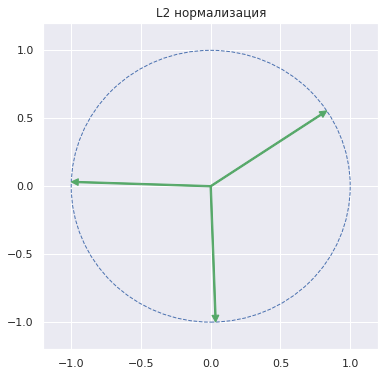

In [ ]:
plt.figure(figsize = (6, 6))

ax = plt.axes()

# в цикле нормализуем каждый из векторов
for v in Normalizer().fit_transform(arr):
  # и выведем его на графике в виде стрелки
  ax.arrow(0, 0, v[0], v[1], width = 0.01, head_width = 0.05, head_length = 0.05, length_includes_head = True, fc = 'g', ec = 'g')

# добавим единичную окружность
circ = plt.Circle((0, 0), radius = 1, edgecolor = 'b', facecolor = 'None', linestyle = '--')
ax.add_patch(circ)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title('L2 нормализация')

plt.show()

Опасность нормализации по строкам

In [ ]:
# данные о росте, весе и возрасте людей
people = np.array([[180, 80, 50],
                   [170, 73, 50]])

In [ ]:
# получается, что у них разный возраст
Normalizer().fit_transform(people)

array([[0.8857221 , 0.39365427, 0.24603392],
       [0.88704238, 0.38090643, 0.26089482]])

#### L1 нормализация

In [ ]:
# возьмем то же массив
arr

array([[  45,   30],
       [  12, -340],
       [-125,    4]])

In [ ]:
# рассчитаем L1 норму для первой строки
np.abs(arr[0][0]) + np.abs(arr[0][1])

75

In [ ]:
# вновь пройдемся по каждому вектору
for row in arr:
  # найдем соответствующую L1 норму
  l1norm = np.abs(row[0]) + np.abs(row[1])
  # и нормализуем векторы
  print((row[0]/l1norm).round(8), (row[1]/l1norm).round(8))

0.6 0.4
0.03409091 -0.96590909
-0.96899225 0.03100775


In [ ]:
# убедимся в том, что вторая вектор-строка имеет единичную L1 норму
np.abs(0.03409091) + np.abs(-0.96590909)

1.0

In [ ]:
# через параметр norm = 'l1' укажем,
# что хотим провести L1 нормализацию
Normalizer(norm = 'l1').fit_transform(arr)

array([[ 0.6       ,  0.4       ],
       [ 0.03409091, -0.96590909],
       [-0.96899225,  0.03100775]])

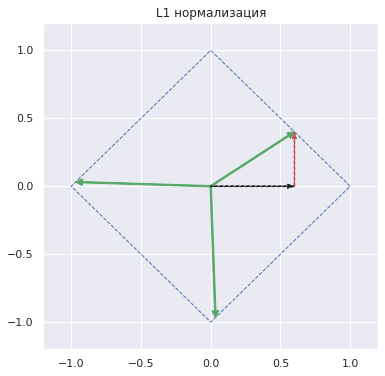

In [ ]:
plt.figure(figsize = (6, 6))
ax = plt.axes()

# выведем L1 нормализованные векторы
for v in Normalizer(norm = 'l1').fit_transform(arr):
  ax.arrow(0, 0, v[0], v[1], width = 0.01, head_width = 0.05, head_length = 0.05, length_includes_head = True, fc = 'g', ec = 'g')

# то, как рассчитывалось расстояние до первого вектора
ax.arrow(0, 0, 0.6, 0, width = 0.005, head_width = 0.03, head_length = 0.05, length_includes_head = True, fc = 'k', ec = 'k', linestyle = '--')
ax.arrow(0.6, 0, 0, 0.4, width = 0.005, head_width = 0.03, head_length = 0.05, length_includes_head = True, fc = 'r', ec = 'r', linestyle = '--')

# а также границы единичных векторов при L1 нормализации
points = [[1, 0], [0, 1], [-1, 0], [0, -1]]
polygon= plt.Polygon(points,  fill = None , edgecolor = 'b', linestyle = '--')
ax.add_patch(polygon)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title('L1 нормализация')

plt.show()

#### Нормализация Чебышёва

In [ ]:
arr

array([[  45,   30],
       [  12, -340],
       [-125,    4]])

In [ ]:
# найдем расстояние Чебышёва для первого вектора
max(np.abs(arr[0][0]), np.abs(arr[0][1]))

45

In [ ]:
# теперь для всего массива
for row in arr:
  # найдем соответствующую норму Чебышёва
  l_inf = max(np.abs(row[0]), np.abs(row[1]))
  # и нормализуем векторы
  print((row[0]/l_inf).round(8), (row[1]/l_inf).round(8))

1.0 0.66666667
0.03529412 -1.0
-1.0 0.032


In [ ]:
# сделаем то же самое с помощью класс Normalizer
Normalizer(norm = 'max').fit_transform(arr)

array([[ 1.        ,  0.66666667],
       [ 0.03529412, -1.        ],
       [-1.        ,  0.032     ]])

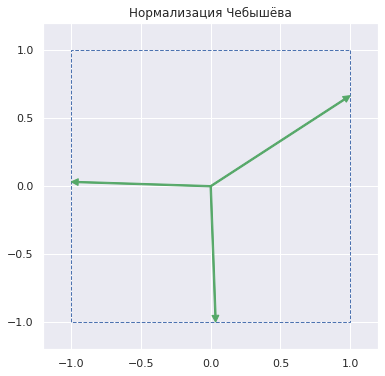

In [ ]:
plt.figure(figsize = (6, 6))
ax = plt.axes()

# выведем нормализованные по расстоянию Чебышёва векторы
for v in Normalizer(norm = 'max').fit_transform(arr):
  ax.arrow(0, 0, v[0], v[1], width = 0.01, head_width = 0.05, head_length = 0.05, length_includes_head = True, fc = 'g', ec = 'g')

# а также границы единичных векторов при такой нормализации
points = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
polygon= plt.Polygon(points,  fill = None , edgecolor = 'b', linestyle = '--')
ax.add_patch(polygon)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title('Нормализация Чебышёва')

plt.show()

## Нелинейные преобразования

In [ ]:
# вновь подгрузим полный датасет boston
boston = pd.read_csv('/content/boston.csv')

#### Логарифмическое преобразование

##### Смысл логарифмического преобразования

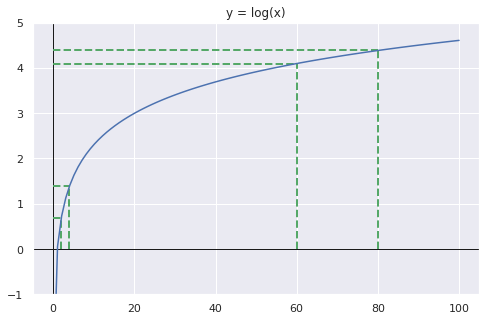

In [ ]:
# построим график логарифмической функции
x = np.linspace(0.05, 100, 100)
y = np.log(x)

ax = plt.axes()

plt.xlim([-5, 105])
plt.ylim([-1, 5])

ax.hlines(y = 0, xmin = -5, xmax = 105, linewidth = 1, color = 'k')
ax.vlines(x = 0, ymin = -1, ymax = 5, linewidth = 1, color = 'k')

plt.plot(x, y)

# и посмотрим как она поступает с промежутками между небольшими
ax.vlines(x = 2, ymin = 0, ymax = np.log(2), linewidth = 2, color = 'g', linestyles = '--')
ax.vlines(x = 4, ymin = 0, ymax = np.log(4), linewidth = 2, color = 'g', linestyles = '--')
ax.hlines(y = np.log(2), xmin = 0, xmax = 2, linewidth = 2, color = 'g', linestyles = '--')
ax.hlines(y = np.log(4), xmin = 0, xmax = 4, linewidth = 2, color = 'g', linestyles = '--')

# и большими значениями
ax.vlines(x = 60, ymin = 0, ymax = np.log(60), linewidth = 2, color = 'g', linestyles = '--')
ax.vlines(x = 80, ymin = 0, ymax = np.log(80), linewidth = 2, color = 'g', linestyles = '--')
ax.hlines(y = np.log(60), xmin = 0, xmax = 60, linewidth = 2, color = 'g', linestyles = '--')
ax.hlines(y = np.log(80), xmin = 0, xmax = 80, linewidth = 2, color = 'g', linestyles = '--')

plt.title('y = log(x)')

plt.show()

##### Скошенное вправо распределение

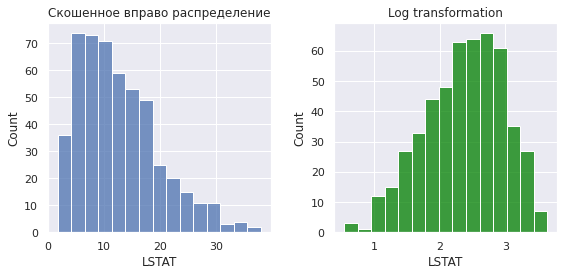

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston.LSTAT, bins = 15, ax = ax[0])
ax[0].set_title('Скошенное вправо распределение')

sns.histplot(x = np.log(boston.LSTAT),
             bins = 15, color = 'green',
            ax = ax[1])
ax[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

In [ ]:
# импортируем необходимые функции
from scipy.stats import skew, kurtosis

In [ ]:
# рассчитаем ассиметричность до и после преобразования
skew(boston.LSTAT), skew(np.log(boston.LSTAT))

(0.9037707431346133, -0.3192822699479382)

In [ ]:
# рассчитаем коэффициент эксцесса до и после преобразования
kurtosis(boston.LSTAT), kurtosis(np.log(boston.LSTAT))

(0.476544755729746, -0.4390590293275558)

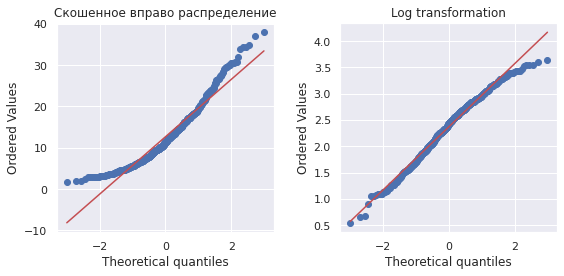

In [ ]:
# построим графики нормальной вероятности
from scipy.stats import probplot

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

probplot(boston.LSTAT, dist = 'norm', plot = ax[0])
ax[0].set_title('Скошенное вправо распределение')

probplot(np.log(boston.LSTAT), dist = 'norm', plot = ax[1])
ax[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

Эффект логарифмического преоразования на выбросы

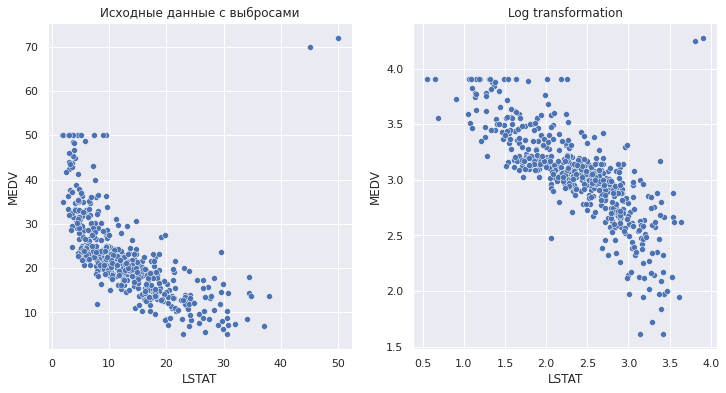

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sns.scatterplot(x = boston_outlier.LSTAT, y = boston_outlier.MEDV, ax = ax[0]).set(title = 'Исходные данные с выбросами')
sns.scatterplot(x = np.log(boston_outlier.LSTAT), y = np.log(boston_outlier.MEDV), ax = ax[1]).set(title = 'Log transformation');

##### Скошенное влево распределение

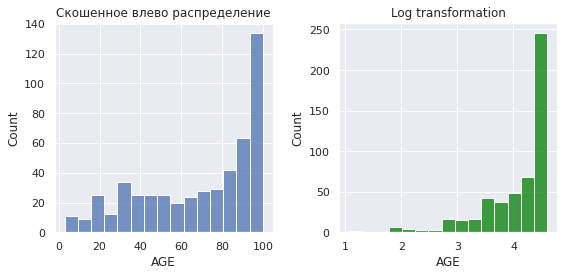

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston.AGE, bins = 15, ax = ax[0])
ax[0].set_title('Скошенное влево распределение')

sns.histplot(x = np.log(boston.AGE),
             bins = 15, color = 'green',
            ax = ax[1])
ax[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

In [ ]:
skew(boston.AGE), skew(np.log(boston.AGE))

(-0.5971855948016143, -1.6706835909283215)

In [ ]:
kurtosis(boston.AGE), kurtosis(np.log(boston.AGE))

(-0.97001392664039, 2.907332087827127)

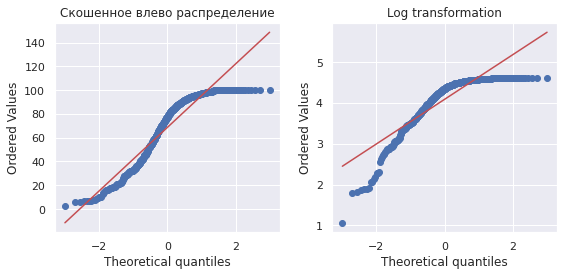

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

probplot(boston.AGE, dist = 'norm', plot = ax[0])
ax[0].set_title('Скошенное влево распределение')

probplot(np.log(boston.AGE), dist = 'norm', plot = ax[1])
ax[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

##### Логарифм нуля и отрицательных значений

In [ ]:
# в переменной ZN есть нулевые значения
# добавим к переменной небольшую константу
np.log(boston.ZN + 0.0001)[:5]

0    2.890377
1   -9.210340
2   -9.210340
3   -9.210340
4   -9.210340
Name: ZN, dtype: float64

In [ ]:
# можно использовать преобразование обратного гиперболического синуса
np.log(boston.ZN + np.sqrt(boston.ZN ** 2 + 1))[:5]

0    3.58429
1    0.00000
2    0.00000
3    0.00000
4    0.00000
Name: ZN, dtype: float64

In [ ]:
np.log(-10 + np.sqrt((-10) ** 2 + 1))

-2.998222950297976

##### Основание логарифма

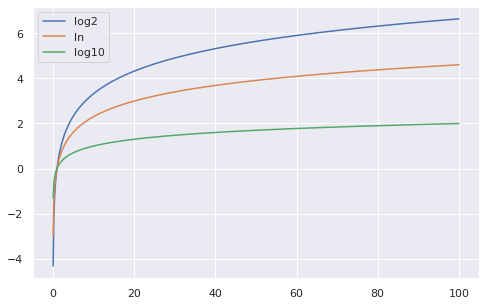

In [ ]:
x = np.linspace(0.05, 100, 500)
y_2 = np.log2(x)
y_ln = np.log(x)
y_10 = np.log10(x)

plt.plot(x, y_2, label = 'log2')
plt.plot(x, y_ln, label = 'ln')
plt.plot(x, y_10, label = 'log10')

plt.legend()

plt.show()

##### Линейная взаимосвязь

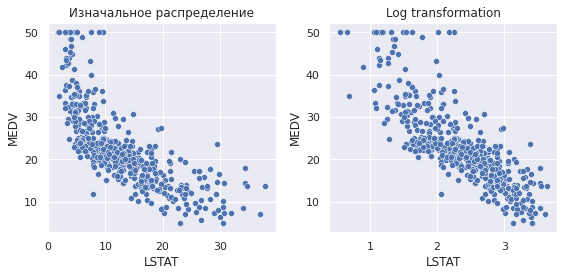

In [ ]:
# визуально оценим "выпрямление" данных
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.scatterplot(x = boston.LSTAT, y = boston.MEDV, ax = ax[0])
ax[0].set_title('Изначальное распределение')

sns.scatterplot(x = np.log(boston.LSTAT), y = boston.MEDV, ax = ax[1])
ax[1].set_title('Log transformation')

plt.tight_layout()

plt.show()

In [ ]:
# посмотрим, как изменится корреляция, если преобразовать
# одну, вторую или сразу обе переменные
boston['LSTAT_log'] = np.log(boston['LSTAT'])
boston['MEDV_log'] = np.log(boston['MEDV'])
                              
boston[['LSTAT', 'LSTAT_log', 'MEDV', 'MEDV_log']].corr()

,LSTAT,LSTAT_log,MEDV,MEDV_log
LSTAT,1.000000,0.944031,-0.737663,-0.805034
LSTAT_log,0.944031,1.000000,-0.815442,-0.822960
MEDV,-0.737663,-0.815442,1.000000,0.953155
MEDV_log,-0.805034,-0.822960,0.953155,1.000000


In [ ]:
# сравним исходный датасет и лог-преобразование + обратную операцию
# (округлим значения, чтобы ошибка округления не мешала сравнению)
boston.MEDV.round(2).equals(np.exp(np.log(boston.MEDV)).round(2))

True

#### Преобразование квадратного корня

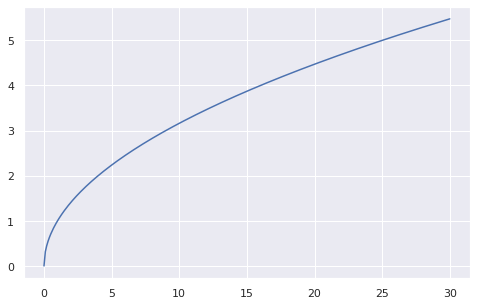

In [ ]:
x = np.linspace(0, 30, 300)
y = np.sqrt(x)

plt.plot(x, y);

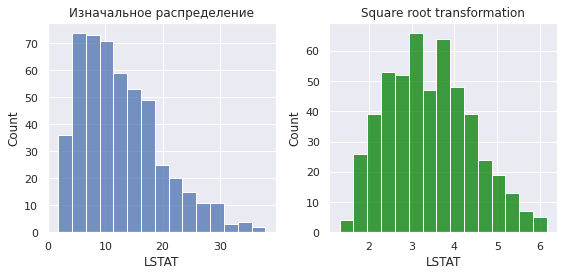

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston.LSTAT, bins = 15, ax = ax[0])
ax[0].set_title('Изначальное распределение')

sns.histplot(x = np.sqrt(boston.LSTAT),
             bins = 15, color = 'green',
            ax = ax[1])
ax[1].set_title('Square root transformation')

plt.tight_layout()
plt.show()

In [ ]:
skew(np.sqrt(boston.LSTAT)), kurtosis(np.sqrt(boston.LSTAT))

(0.30647851994358943, -0.4830777032469129)

In [ ]:
boston['LSTAT_sqrt'] = np.sqrt(boston['LSTAT'])
boston['MEDV_sqrt'] = np.sqrt(boston['MEDV'])
                              
boston[['LSTAT', 'LSTAT_sqrt', 'MEDV', 'MEDV_sqrt']].corr()

,LSTAT,LSTAT_sqrt,MEDV,MEDV_sqrt
LSTAT,1.000000,0.986688,-0.737663,-0.781287
LSTAT_sqrt,0.986688,1.000000,-0.785109,-0.816253
MEDV,-0.737663,-0.785109,1.000000,0.989148
MEDV_sqrt,-0.781287,-0.816253,0.989148,1.000000


#### Лестница степеней Тьюки

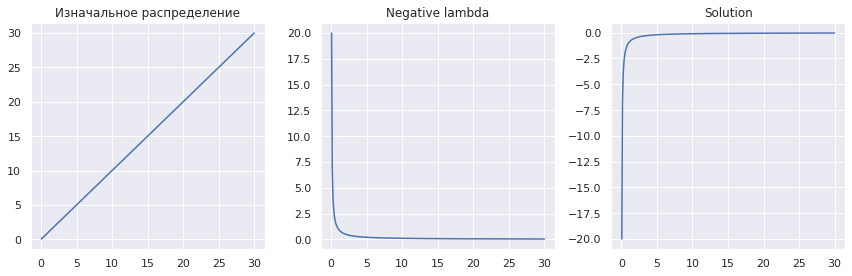

In [ ]:
x = np.linspace(0.05, 30, 300)

y0 = x
y1 = x ** (-1)
y2 = -(x ** (-1))

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

ax[0].plot(x, y0);
ax[0].set_title('Изначальное распределение')

ax[1].plot(x, y1);
ax[1].set_title('Negative lambda')

ax[2].plot(x, y2);
ax[2].set_title('Solution')

plt.tight_layout()

plt.show()

In [ ]:
def tukey(x, y):

  x, y = x.to_numpy(), y.to_numpy()

  # в lambdas поместим возможные степени
  lambdas = [-2, -1, -1/2, 0, 1/2, 1, 2]
  # в corrs будем записывать получающиеся корреляции
  corrs = []

  # в цикле последовательно применим каждую lambda
  for l in lambdas:

    if l < 0:
      # рассчитаем коэффициент корреляции Пирсона и добавим результат в corrs
      corrs.append(np.corrcoef(x ** l, y ** l)[0][1])

    elif l == 0:
      corrs.append(np.corrcoef(np.log(x + np.sqrt(x**2 + 1)),
                               np.log(y + np.sqrt(y**2 + 1)))[0][1])

    else:
      corrs.append(np.corrcoef(-(x ** l), -(y ** l))[0][1])

  # теперь найдем индекс наибольшего значения корреляции
  idx = np.argmax(np.abs(corrs))

  # выведем оптимальную lambda и соответствующую корреляцию
  return lambdas[idx], np.round(corrs[idx], 3)

In [ ]:
# найдем оптимальную lambda для LSTAT
tukey(boston.LSTAT, boston.MEDV)

(0, -0.824)

In [ ]:
# найдем оптимальные lambda для каждого признака
for col in boston[['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']]:
  print(str(col) + '\t' + str(tukey(boston[col], boston.MEDV)))

CRIM	(0, -0.593)
NOX	(-0.5, -0.526)
RM	(2, 0.724)
AGE	(0.5, -0.402)
DIS	(-1, 0.489)
RAD	(0, -0.44)
TAX	(-0.5, -0.558)
PTRATIO	(0.5, -0.509)
LSTAT	(0, -0.824)


In [ ]:
# рассчитаем корреляцию признаков до преобразования с целевой переменной
boston[['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']].corr().MEDV.round(2)

CRIM      -0.39
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [ ]:
# создадим датафрейм с преобразованными данными
boston_transformed = {}

boston_transformed['RM'] = boston.RM ** 2
boston_transformed['PTRATIO'] = np.sqrt(boston.PTRATIO)
boston_transformed['LSTAT'] = np.log(boston.LSTAT)
boston_transformed['MEDV'] = boston.MEDV

boston_transformed = pd.DataFrame(boston_transformed,
                                  columns = ['RM', 'PTRATIO', 'LSTAT', 'MEDV'])

boston_transformed.head()

,RM,PTRATIO,LSTAT,MEDV
0,43.230625,3.911521,1.605430,24.0
1,41.229241,4.219005,2.212660,21.6
2,51.624225,4.219005,1.393766,34.7
3,48.972004,4.324350,1.078410,33.4
4,51.079609,4.324350,1.673351,36.2


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(boston[['RM', 'PTRATIO', 'LSTAT']], boston.MEDV)
model.score(boston[['RM', 'PTRATIO', 'LSTAT']], boston.MEDV)

0.6786241601613112

In [ ]:
model = LinearRegression()
model.fit(boston_transformed[['RM', 'PTRATIO', 'LSTAT']], boston_transformed.MEDV)
model.score(boston_transformed[['RM', 'PTRATIO', 'LSTAT']], boston_transformed.MEDV)

0.7446785206677597

#### Преобразование Бокса-Кокса

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'box-cox')

# найдем оптимальный параметр лямбда
pt.fit(boston[['LSTAT']])

pt.lambdas_

array([0.22776737])

In [ ]:
# преобразуем данные
bc_pt = pt.transform(boston[['LSTAT']])

# метод .transform() возвращает двумерный массив
bc_pt.shape

(506, 1)

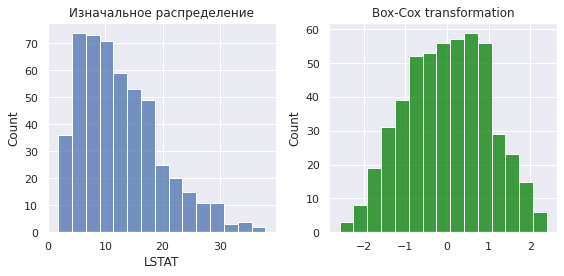

In [ ]:
# сравним изначальное распределение и распределение после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston.LSTAT, bins = 15, ax = ax[0])
ax[0].set_title('Изначальное распределение')

# так как на выходе метод .transform() выдает двумерный массив,
# его необходимо преобразовать в одномерный
sns.histplot(x = bc_pt.flatten(),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Box-Cox transformation')

plt.tight_layout()
plt.show()

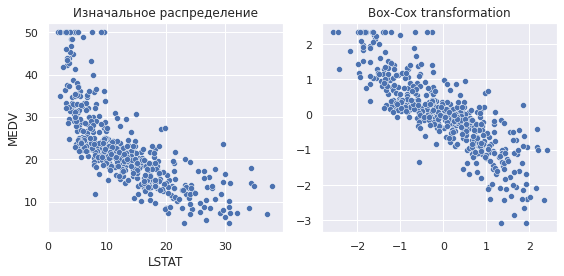

In [ ]:
# оценим изменение взаимосвязи после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.scatterplot(x = boston.LSTAT, y = boston.MEDV, ax = ax[0])
ax[0].set_title('Изначальное распределение')

# можно использовать функцию power_transform(),
# она действует аналогично классу, но без estimator
sns.scatterplot(x = power_transform(boston[['LSTAT']], method = 'box-cox').flatten(),
                y = power_transform(boston[['MEDV']], method = 'box-cox').flatten(),
                ax = ax[1])
ax[1].set_title('Box-Cox transformation')

plt.tight_layout()

plt.show()

In [ ]:
# посмотрим на достигнутый коэффициент корреляции
pd.DataFrame(power_transform(boston[['LSTAT', 'MEDV']], method = 'box-cox'), 
             columns = [['LSTAT', 'MEDV']]).corr()

,LSTAT,MEDV
LSTAT,1.000000,-0.830424
MEDV,-0.830424,1.000000


In [ ]:
# сравним корреляцию признаков с целевой переменной
# после преобразования Бокса-Кокса
MEDV_bc = power_transform(boston[['MEDV']], method = 'box-cox').flatten()

for col in boston[['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']]:
  col_bc = power_transform(boston[[col]], method = 'box-cox').flatten()
  print(col + '\t' + str(np.round(np.corrcoef(col_bc, MEDV_bc)[0][1], 3)))

CRIM	-0.528
NOX	-0.5
RM	0.64
AGE	-0.452
DIS	0.392
RAD	-0.403
TAX	-0.538
PTRATIO	-0.522
LSTAT	-0.83


In [ ]:
# возьмем признаки RM, PTRATIO, LSTAT и целевую переменную MEDV
# и применим преобразование
pt = PowerTransformer(method = 'box-cox')
boston_bc = pt.fit_transform(boston[['RM', 'PTRATIO', 'LSTAT', 'MEDV']])
boston_bc = pd.DataFrame(boston_bc, columns = ['RM', 'PTRATIO', 'LSTAT', 'MEDV'])

# построим линейную регрессию
# в данном случае показатель чуть хуже, чем при лестнице Тьюки
model = LinearRegression()
model.fit(boston_bc[['RM', 'PTRATIO', 'LSTAT']], boston_bc.MEDV)
model.score(boston_bc[['RM', 'PTRATIO', 'LSTAT']], boston_bc.MEDV)

0.733184521322797

In [ ]:
# посмотрим на лямбды
pt.lambdas_

array([0.44895979, 4.35021543, 0.22776737, 0.2166209 ])

In [ ]:
# выполним обратное преобразование
pd.DataFrame(pt.inverse_transform(boston_bc),
             columns = ['RM', 'PTRATIO', 'LSTAT', 'MEDV']).head()

,RM,PTRATIO,LSTAT,MEDV
0,6.575,15.3,4.98,24.0
1,6.421,17.8,9.14,21.6
2,7.185,17.8,4.03,34.7
3,6.998,18.7,2.94,33.4
4,7.147,18.7,5.33,36.2


#### Преобразование Йео-Джонсона

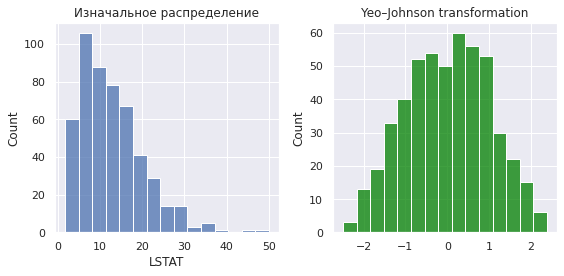

In [ ]:
# попробуем преобразование Йео-Джонсона
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston_outlier.LSTAT, bins = 15, ax = ax[0])
ax[0].set_title('Изначальное распределение')

sns.histplot(x = power_transform(boston[['LSTAT']], method = 'yeo-johnson').flatten(),
             bins = 15, color = 'green',
            ax = ax[1])
ax[1].set_title('Yeo–Johnson transformation')

plt.tight_layout()
plt.show()

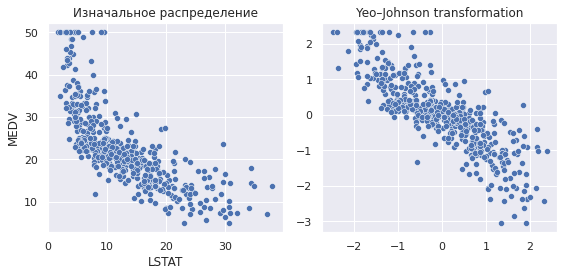

In [ ]:
# посмотрим как изменится линейность взаимосвязи
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.scatterplot(x = boston.LSTAT, y = boston.MEDV, ax = ax[0])
ax[0].set_title('Изначальное распределение')

sns.scatterplot(x = power_transform(boston[['LSTAT']], method = 'yeo-johnson').flatten(),
                y = power_transform(boston[['MEDV']], method = 'yeo-johnson').flatten(),
                ax = ax[1])
ax[1].set_title('Yeo–Johnson transformation')

plt.tight_layout()

plt.show()

In [ ]:
# возьмем те же признаки и целевую переменную, преобразуем их
# преобразование Йео-Джонсона является методом по умолчанию
pt = PowerTransformer()
boston_yj = pt.fit_transform(boston[['RM', 'PTRATIO', 'LSTAT', 'MEDV']])
boston_yj = pd.DataFrame(boston_yj, columns = ['RM', 'PTRATIO', 'LSTAT', 'MEDV'])

# построим модель
model = LinearRegression()
model.fit(boston_yj.iloc[:, :3], boston_yj.iloc[:, -1])
model.score(boston_yj.iloc[:, :3], boston_yj.iloc[:, -1])

0.7333775808517045

#### QuantileTransformer

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# приведем переменные с выбросами (!) к нормальному распределению
# с помощью квантиль-функции
qt = QuantileTransformer(n_quantiles = len(boston_outlier),
                         output_distribution = 'normal',
                         random_state = 42)

# для каждого из столбцов вычислим квантили нормального распределения,
# соответствующие заданному выше количеству квантилей (n_quantiles)
# и преобразуем (map) данные к нормальному распределению
boston_qt = pd.DataFrame(qt.fit_transform(boston_outlier),
                         columns = boston_outlier.columns)

# посмотрим на значения, на основе которых будут рассчитаны квантили
qt.quantiles_[-5:]

array([[34.77, 50.  ],
       [36.98, 50.  ],
       [37.97, 50.  ],
       [45.  , 70.  ],
       [50.  , 72.  ]])

In [ ]:
# посмотрим на соответствующие им квантили нормального распределения
qt.references_[-5:]

array([0.99211045, 0.99408284, 0.99605523, 0.99802761, 1.        ])

In [ ]:
# рассчитаем предпоследнее значение с помощью библиотеки scipy
from scipy.stats import norm

norm.ppf(0.99802761, loc = 0, scale = 1)

2.8825440308212347

In [ ]:
# сравним с преобразованными значениями
boston_qt.LSTAT.sort_values()[-5:]

373    2.413985
414    2.517047
374    2.656761
506    2.882545
507    5.199338
Name: LSTAT, dtype: float64

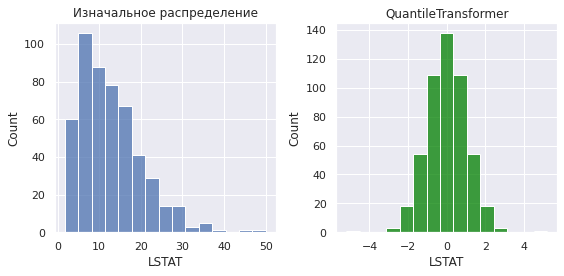

In [ ]:
# выведем результат
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston_outlier.LSTAT, bins = 15, ax = ax[0])
ax[0].set_title('Изначальное распределение')

sns.histplot(x = boston_qt.LSTAT,
             bins = 15, color = 'green',
            ax = ax[1])
ax[1].set_title('QuantileTransformer')

plt.tight_layout()
plt.show()

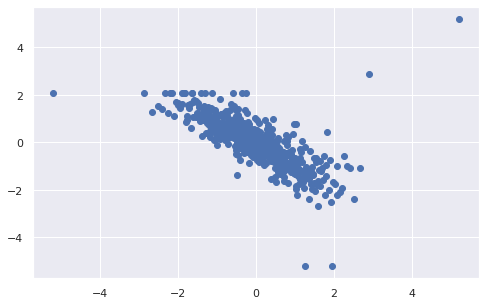

In [ ]:
# посмотрим выправилась ли взаимосвязь
plt.scatter(boston_qt.LSTAT, boston_qt.MEDV);

In [ ]:
# эффект выбросов сохранился
max(boston_qt.LSTAT), max(boston_qt.MEDV)

(5.19933758270342, 5.19933758270342)

In [ ]:
# сравним исходную корреляцию
boston_outlier[['LSTAT', 'MEDV']].corr().iloc[0,1]

-0.5772033139947359

In [ ]:
# с корреляцией после преобразования
boston_qt.corr().iloc[0,1]

-0.7037287662365327

In [ ]:
# посмотрим на корреляцию после преобразования Йео-Джонсона
boston_yj = pd.DataFrame(power_transform(boston_outlier, method = 'yeo-johnson'), 
                         columns = boston_outlier.columns)

boston_yj.corr().iloc[0,1]

-0.7661930913306837

## Дополнительные материалы

### Pipeline и ColumnTransformer

#### ColumnTransformer

In [ ]:
# создадим датасет с данными о клиентах банка
scoring = {
    'Name' : ['Иван', 'Николай', 'Алексей', 'Александра', 'Евгений', 'Елена'],
    'Age' : [35, 43, 21, 34, 24, 27],
    'Experience' : [7, 13, 2, np.nan, 4, 12],
    'Salary' : [95, 135, 73, 100, 78, 110],
    'Credit_score' : ['Good', 'Good', 'Bad', 'Medium', 'Medium', 'Good'],
    'Outcome' : [1, 1, 0, 1, 0, 1]
}

scoring = pd.DataFrame(scoring)
scoring

,Name,Age,Experience,Salary,Credit_score,Outcome
0,Иван,35,7.0,95,Good,1
1,Николай,43,13.0,135,Good,1
2,Алексей,21,2.0,73,Bad,0
3,Александра,34,NaN,100,Medium,1
4,Евгений,24,4.0,78,Medium,0
5,Елена,27,12.0,110,Good,1


In [ ]:
# разобьем данные на признаки и целевую переменную
X = scoring.iloc[:, 1 :-1]
y = scoring.Outcome

# поместим название количественных и категориальных признаков в списки
num_col = ['Age', 'Experience', 'Salary']
cat_col = ['Credit_score']

# ColumnTransformer позволяет применять разные преобразователи к разным столбцам
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# создадим объекты преобразователей для количественных
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# и категориального признака
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories = [['Bad', 'Medium', 'Good']])

# поместим их в отдельные пайплайны
num_transformer = make_pipeline(imputer, scaler)
cat_transformer = make_pipeline(encoder)

# поместим пайплайны в ColumnTransformer
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# создадим объект модели, которая будет использовать все признаки
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# создадим еще один пайплайн, который будет включать объект ColumnTransformer и
# объект модели
pipe = make_pipeline(preprocessor, model)

pipe.fit(X, y)

# сделаем прогноз
pipe.predict(X)

array([1, 1, 0, 1, 0, 1])

#### Библиотека joblib

##### Сохранение пайплайна

In [ ]:
import joblib

# сохраним пайплайн в файл с расширением .joblib
joblib.dump(pipe, 'pipe.joblib')

# импортируем из файла
new_pipe = joblib.load('pipe.joblib')

# обучим модель и сделаем прогноз
new_pipe.fit(X, y)
pipe.predict(X)

array([1, 1, 0, 1, 0, 1])

##### Кэширование функции

In [ ]:
import time

# напишем функцию, которая принимает список чисел 
# и выдает их квадрат
def square_range(start_num, end_num):

  res = []
  # пройдемся по заданному перечню
  for i in range(start_num, end_num):
    res.append(i ** 2)
    # искусственно замедлим исполнение
    time.sleep(0.5)
  
  return res

start = time.time()
res = square_range(1, 21)
end = time.time()

# посмотрим на время исполнения и финальный результат
print(end - start)
print(res)

10.011821508407593
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [ ]:
# определим, куда мы хотим сохранить кэш
location = '/content/'

# используем класс Memory
memory = joblib.Memory(location, verbose = 0)

def square_range_cached(start_num, end_num):

  res = []
  # пройдемся по заданному перечню
  for i in range(start_num, end_num):
    res.append(i ** 2)
    # искусственно замедлим исполнение
    time.sleep(0.5)
  
  return res

# поместим в кэш
square_range_cached = memory.cache(square_range_cached)

# при первом вызове функции время исполнения не изменится
start = time.time()
res = square_range_cached(1, 21)
end = time.time()

print(end - start)
print(res)

10.015207290649414
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [ ]:
start = time.time()
res = square_range_cached(1, 21)
end = time.time()

print(end - start)
print(res)

0.0009303092956542969
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


##### Параллелизация

In [ ]:
n_cpu = joblib.cpu_count()
n_cpu

2

In [ ]:
def slow_square(x):
  time.sleep(1)
  return x ** 2

In [ ]:
%time [slow_square(i) for i in range(10)]

CPU times: user 66.4 ms, sys: 2.91 ms, total: 69.3 ms
Wall time: 10 s


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [ ]:
from joblib import Parallel, delayed

# функция delayed() разделяет исполнение кода на несколько задач (функций)
delayed_funcs = [delayed(slow_square)(i) for i in range(10)]

# класс Parallel отвечает за параллелизацию
# если указать n_jobs = -1, будут использованы все доступные CPU
parallel_pool = Parallel(n_jobs = n_cpu)

%time parallel_pool(delayed_funcs)

CPU times: user 59.7 ms, sys: 53.2 ms, total: 113 ms
Wall time: 5.66 s


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [ ]:
# для наглядности выведем задачи, созданные функцией delayed()
delayed_funcs

[(<function __main__.slow_square(x)>, (0,), {}),
 (<function __main__.slow_square(x)>, (1,), {}),
 (<function __main__.slow_square(x)>, (2,), {}),
 (<function __main__.slow_square(x)>, (3,), {}),
 (<function __main__.slow_square(x)>, (4,), {}),
 (<function __main__.slow_square(x)>, (5,), {}),
 (<function __main__.slow_square(x)>, (6,), {}),
 (<function __main__.slow_square(x)>, (7,), {}),
 (<function __main__.slow_square(x)>, (8,), {}),
 (<function __main__.slow_square(x)>, (9,), {})]

### Встраивание функций и классов в sklearn

#### FunctionTransformer

In [ ]:
# напишем простой encoder
# будем передавать в функцию данные, столбец, который нужно кодировать
# и схему кодирования (map)
def encoder(df, col, map_dict):
  df_map = df.copy()
  df_map[col] = df_map[col].map(map_dict)
  return df_map

In [ ]:
map_dict = {'Bad' : 0,
            'Medium' : 1,
            'Good': 2}

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# поместим функцию в класс FunctionTransformer и создадим объект этого класса
# передадим параметры в виде словаря
encoder = FunctionTransformer(func = encoder,
                              kw_args = {'col' : 'Credit_score',
                                         'map_dict' : map_dict})

In [ ]:
# FunctionTransformer автоматически создаст методы
# в частности, метод .fit_transform()
encoder.fit_transform(X)

,Age,Experience,Salary,Credit_score
0,35,7.0,95,2
1,43,13.0,135,2
2,21,2.0,73,0
3,34,NaN,100,1
4,24,4.0,78,1
5,27,12.0,110,2


#### Класс с BaseEstimator и TransformerMixin

In [ ]:
# класс BaseEstimator создает методы .get_params() и .set_params()
# класс TransformerMixin создает .fit_transform()
from sklearn.base import BaseEstimator, TransformerMixin

class Encode(BaseEstimator, TransformerMixin):
    
  # при создании объекта класса передаем столбец и схему кодирования
  def __init__(self, col, map_dict):
    self.col = col
    self.map_dict = map_dict

  def fit(self, df, y = None):
    return self

  def transform(self, df, y = None):
    df_map = df.copy()
    # применим преобразование
    df_map[self.col] = df_map[self.col].map(self.map_dict)
    return df_map

  def inverse_transform(self, df, y = None):
    df_inv_map = df.copy()
    # поменяем ключи и значения местами
    inv_map = {v: k for k, v in self.map_dict.items()}
    # применим обратное преобразование
    df_inv_map[self.col] = df_inv_map[self.col].map(inv_map)
    return df_inv_map

In [ ]:
encoder = Encode('Credit_score', dict(Bad = 0, Medium = 1, Good = 2))

X_trans = encoder.fit_transform(X)
X_trans

,Age,Experience,Salary,Credit_score
0,35,7.0,95,2
1,43,13.0,135,2
2,21,2.0,73,0
3,34,NaN,100,1
4,24,4.0,78,1
5,27,12.0,110,2


In [ ]:
encoder.inverse_transform(X_trans)

,Age,Experience,Salary,Credit_score
0,35,7.0,95,Good
1,43,13.0,135,Good
2,21,2.0,73,Bad
3,34,NaN,100,Medium
4,24,4.0,78,Medium
5,27,12.0,110,Good


In [ ]:
# поместим созданный класс в пайплайн
imputer = SimpleImputer(strategy = 'mean')
scaler = StandardScaler()

encoder = Encode('Credit_score', dict(Bad = 0, Medium = 1, Good = 2))

num_transformer = make_pipeline(imputer, scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

model = LogisticRegression()

pipe = make_pipeline(preprocessor, model)
pipe.fit(X, y)
pipe.predict(X)

array([1, 1, 0, 1, 0, 1])